<a href="https://colab.research.google.com/github/Takshay20/Titanic-Data-Analysis/blob/main/Task_4_Complete_Mini_Visualization_Dashboard_(Titanic_Dataset).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [20]:
# Imports & settings
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (9,5)

In [21]:
# Upload train.csv in Colab (or load locally)
try:
    from google.colab import files, drive  # colab environment
    uploaded = files.upload()  # choose train.csv from your computer
    import io
    df = pd.read_csv(io.BytesIO(list(uploaded.values())[0]))
    print("Loaded uploaded file.")
except Exception as e:
    # fallback for local jupyter
    df = pd.read_csv("train.csv")
    print("Loaded train.csv from local path.")

print("Shape:", df.shape)
df.columns.tolist()


Saving train.csv to train (1).csv
Loaded uploaded file.
Shape: (891, 12)


['PassengerId',
 'Survived',
 'Pclass',
 'Name',
 'Sex',
 'Age',
 'SibSp',
 'Parch',
 'Ticket',
 'Fare',
 'Cabin',
 'Embarked']

**Quick exploration & missing values**

In [22]:
# Step 3: Quick peek & missing value summary
display(df.head(6))
print("\nInfo:")
display(df.info())
print("\nMissing values per column:")
print(df.isnull().sum())

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q



Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


None


Missing values per column:
PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


**Keep useful columns & fill missing values**

In [23]:
# Step 4 (Corrected): Keep relevant cols and fill missing values properly
cols_keep = ['PassengerId','Survived','Pclass','Name','Sex','Age','SibSp','Parch','Ticket','Fare','Cabin','Embarked']
df = df[cols_keep].copy()

# Correct new pandas way:
df = df.fillna({
    'Age': df['Age'].median(),
    'Embarked': df['Embarked'].mode()[0],
    'Fare': df['Fare'].median()
})

# Check missing values again
df.isnull().sum()


,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


**Feature engineering (Title, Deck, FamilySize, IsAlone, AgeGroup, FareBand)**

In [24]:
# Step 5: Feature engineering
# Deck from Cabin
df['Deck'] = df['Cabin'].fillna('U').astype(str).str[0]

# Title from Name
df['Title'] = df['Name'].str.extract(r',\s*([^\.]+)\.', expand=False).str.strip()
title_map = {
    'Mlle': 'Miss', 'Ms': 'Miss', 'Mme': 'Mrs',
    'Lady':'Rare','Countess':'Rare','Capt':'Rare','Col':'Rare','Don':'Rare','Dr':'Rare','Major':'Rare','Rev':'Rare',
    'Sir':'Rare','Jonkheer':'Rare','Dona':'Rare'
}
df['Title'] = df['Title'].replace(title_map)
rare_titles = df['Title'].value_counts()[df['Title'].value_counts() < 10].index
df['Title'] = df['Title'].apply(lambda x: 'Rare' if x in rare_titles else x)

# Family size & alone flag
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

# Age group
df['AgeGroup'] = pd.cut(df['Age'], bins=[0,12,18,30,45,60,100],
                        labels=['Child','Teen','YoungAdult','Adult','MidAge','Senior'])

# Fare bands (quartiles)
df['FareBand'] = pd.qcut(df['Fare'].rank(method='first'), 4, labels=['Low','Medium','High','VeryHigh'])

# Check new columns
df[['PassengerId','Survived','Title','Deck','FamilySize','IsAlone','Age','AgeGroup','Fare','FareBand']].head(6)


,PassengerId,Survived,Title,Deck,FamilySize,IsAlone,Age,AgeGroup,Fare,FareBand
0,1,0,Mr,U,2,0,22.0,YoungAdult,7.2500,Low
1,2,1,Mrs,C,2,0,38.0,Adult,71.2833,VeryHigh
2,3,1,Miss,U,1,1,26.0,YoungAdult,7.9250,Medium
3,4,1,Mrs,C,2,0,35.0,Adult,53.1000,VeryHigh
4,5,0,Mr,U,1,1,35.0,Adult,8.0500,Medium
5,6,0,Mr,U,1,1,28.0,YoungAdult,8.4583,Medium


**Plot 1: Overall survival count**

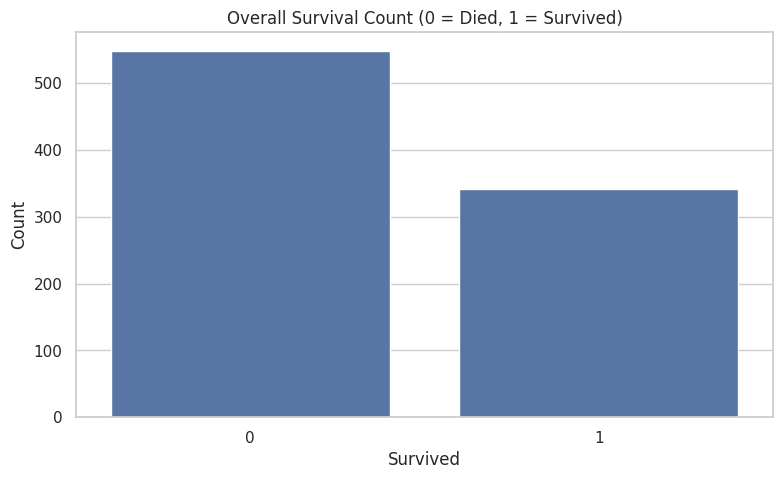

In [25]:
plt.figure()
sns.countplot(x='Survived', data=df)
plt.title('Overall Survival Count (0 = Died, 1 = Survived)')
plt.xlabel('Survived')
plt.ylabel('Count')
plt.show()


**Plot 2 - Survival by Sex**

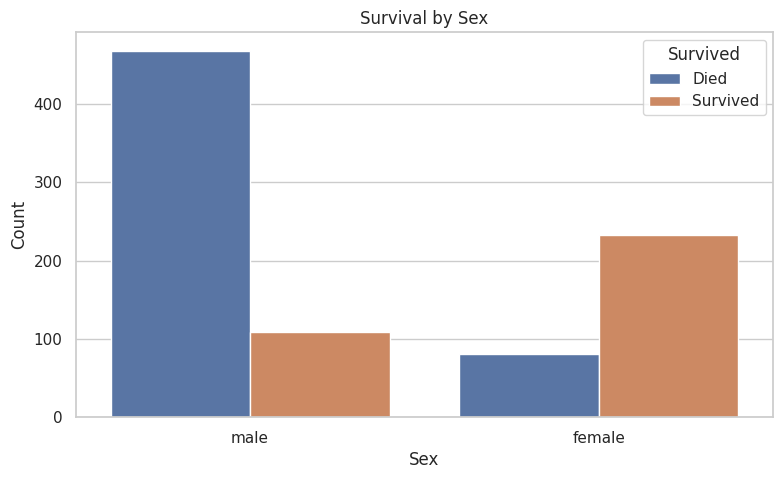

In [26]:
plt.figure()
sns.countplot(x='Sex', hue='Survived', data=df)
plt.title('Survival by Sex')
plt.ylabel('Count')
plt.legend(title='Survived', labels=['Died','Survived'])
plt.show()


**Plot 3 - Survival rate by Pclass**

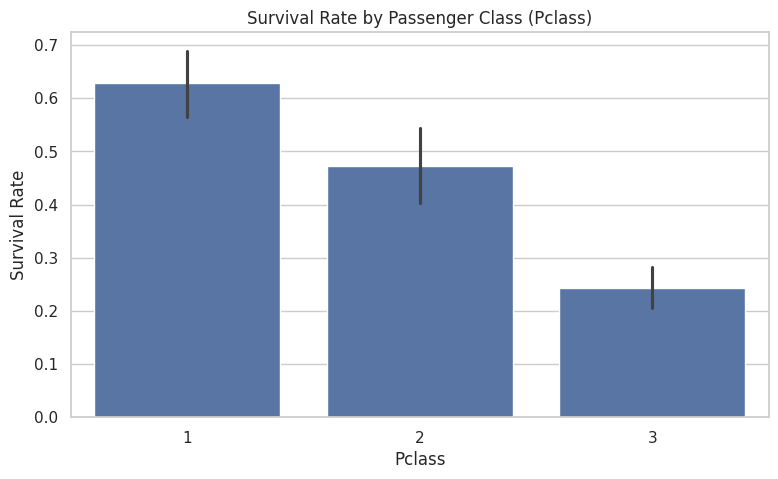

In [27]:
plt.figure()
sns.barplot(x='Pclass', y='Survived', data=df)
plt.title('Survival Rate by Passenger Class (Pclass)')
plt.ylabel('Survival Rate')
plt.show()

**Plot 4 - Survival by Title**

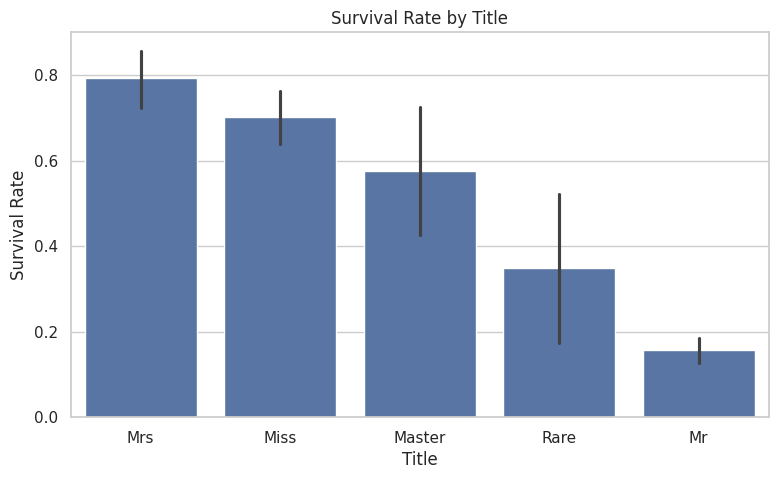

In [28]:
plt.figure(figsize=(9,5))
order = df.groupby('Title')['Survived'].mean().sort_values(ascending=False).index
sns.barplot(x='Title', y='Survived', data=df, order=order)
plt.title('Survival Rate by Title')
plt.ylabel('Survival Rate')
plt.show()


**Plot 5 - Age distribution by survival**

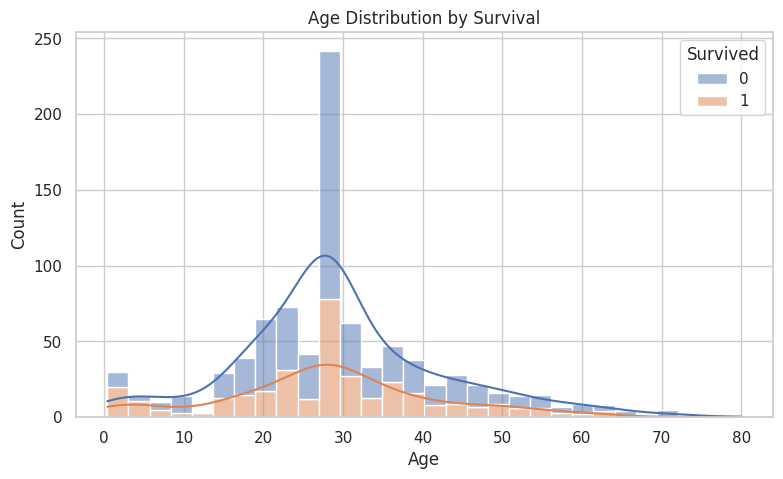

In [29]:
plt.figure()
sns.histplot(data=df, x='Age', hue='Survived', bins=30, kde=True, multiple='stack')
plt.title('Age Distribution by Survival')
plt.show()


**Plot 6 - Fare distribution by survival (log scale)**

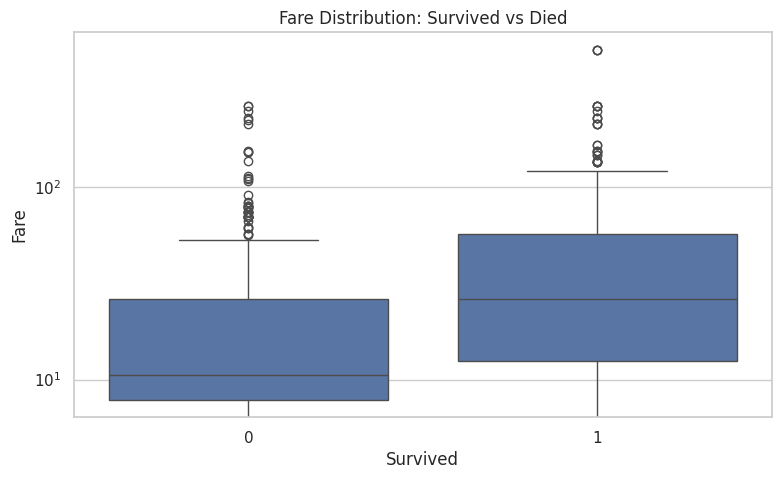

In [30]:
plt.figure()
sns.boxplot(x='Survived', y='Fare', data=df)
plt.title('Fare Distribution: Survived vs Died')
plt.yscale('log')
plt.show()


**Plot 7 - Family size vs survival**

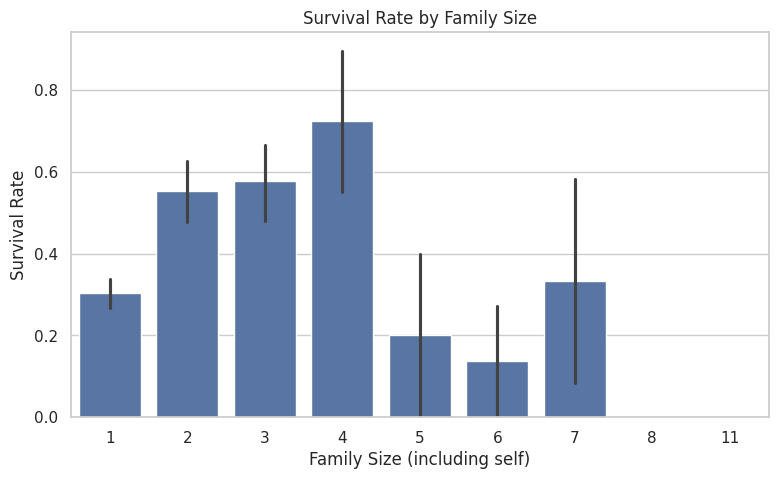

In [31]:
plt.figure()
sns.barplot(x='FamilySize', y='Survived', data=df)
plt.title('Survival Rate by Family Size')
plt.xlabel('Family Size (including self)')
plt.ylabel('Survival Rate')
plt.show()


**Plot 8 - Deck vs survival**

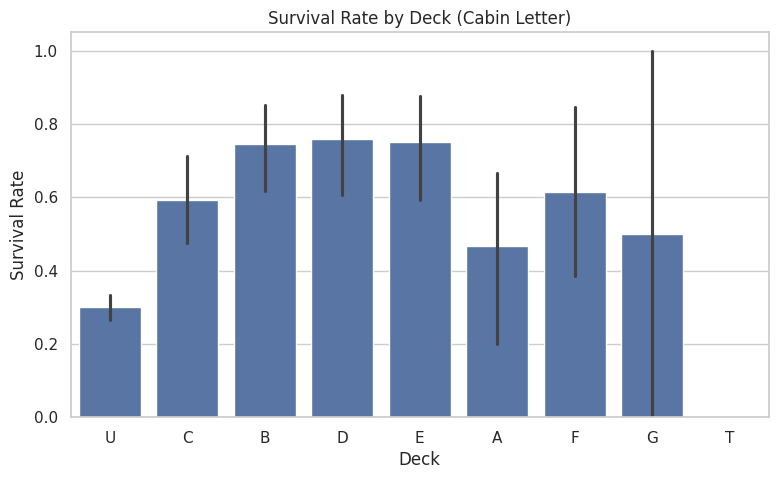

In [32]:
plt.figure(figsize=(9,5))
order = df['Deck'].value_counts().index
sns.barplot(x='Deck', y='Survived', data=df, order=order)
plt.title('Survival Rate by Deck (Cabin Letter)')
plt.ylabel('Survival Rate')
plt.show()


**Plot 9 - Embarked vs survival**

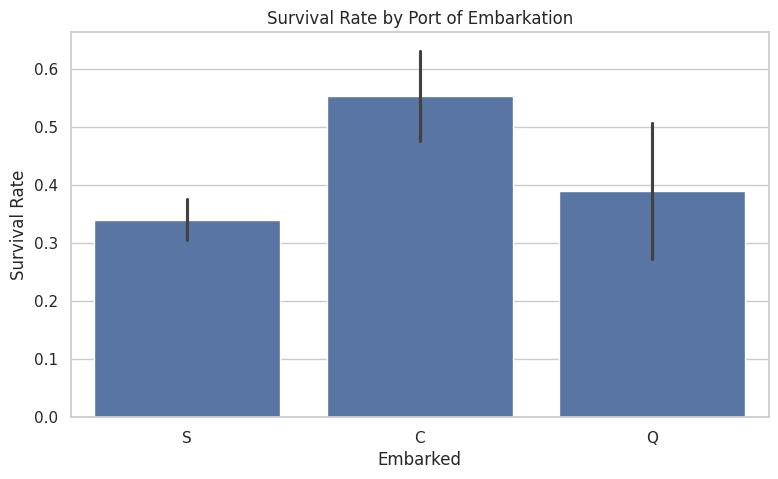

In [33]:
plt.figure()
sns.barplot(x='Embarked', y='Survived', data=df)
plt.title('Survival Rate by Port of Embarkation')
plt.ylabel('Survival Rate')
plt.show()


**Plot 10 - Facet: Pclass split by Sex**

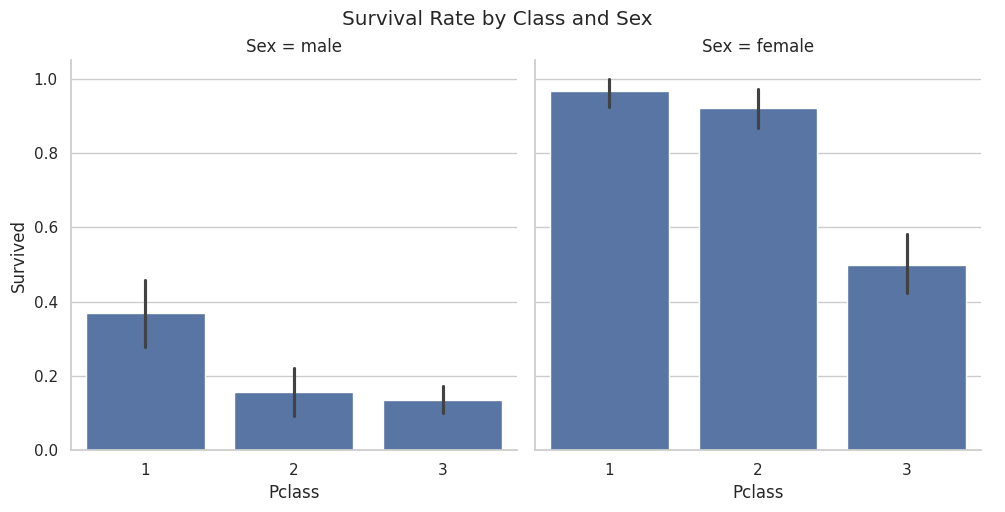

In [34]:
g = sns.catplot(x='Pclass', y='Survived', col='Sex', kind='bar', data=df, height=5)
g.fig.suptitle('Survival Rate by Class and Sex', y=1.02)
plt.show()


**Correlation heatmap**

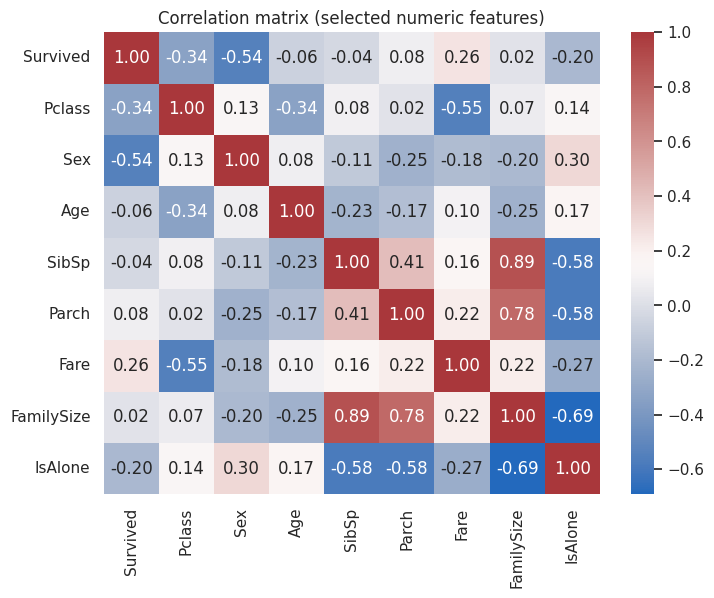

In [35]:
df_corr = df.copy()
le = LabelEncoder()
for c in ['Sex','Title','Deck','Embarked','AgeGroup','FareBand']:
    df_corr[c] = le.fit_transform(df_corr[c].astype(str))
corr = df_corr[['Survived','Pclass','Sex','Age','SibSp','Parch','Fare','FamilySize','IsAlone']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='vlag')
plt.title('Correlation matrix (selected numeric features)')
plt.show()


# Final Insights — Task 4 Dashboard

1. **Gender & Class strongest predictors:** Females and 1st class passengers had the highest survival rates.  
2. **Title captures social/age signal:** Titles (Mrs, Miss, Mr, etc.) help group passengers meaningfully.  
3. **Age & Fare matter, but interact:** Children and higher-fare passengers tended to survive more, but these overlap with class and sex.  
4. **Family effects:** Small families (2–4) tended to have better survival.  
5. **Missing cabin info (Deck='U') is informative:** Known decks show variable survival; many unknowns exist.